This code was used to generate the figures in the PNAS letter "On the role of MFD and UvrD in transcription coupled DNA repair" 

The input files are bedfiles uploaded by Adebali et al. from the GEO database. Acession #GSE92734

Code is taken from process_file.py and assembled in this notebook to make more sense.

All code was written by Britney Martinez Graduate Student in Evgeny Nudler's lab

In [1]:
#Packages used in this analysis
import collections
import pandas as pd
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import stats

In [62]:
'''
gen_df takes in a list of bedfiles for each sample and seperates alignment counts on whether they map to the TS or 
NTS. This assumes the first file in the list is the "plus" file and the second file in the list is the "minus" file
It returns a DF that has the sample seperated into aligned reads that map to TS or NTS.

All files in Plus file that map to '+' are NTS -because alignment files give coding strand
All files in Pluse file that map to '-' are TS 
All files in Minus file that map to '-' are NTS
All files in Minus file that map ti '+' are TS
'''


def gen_df(sample_lis,sample):
    plus_df=pd.read_table(sample_lis[0],header=None)
    plus_df.columns=[0,1,2,3,4,5,'plus_count']
    minus_df=pd.read_table(sample_lis[1],header=None)
    minus_df.columns=[0,1,2,3,4,5,'minus_count']
    merge_df=pd.merge(plus_df,minus_df)
    plus_genes=merge_df[5]=='+'
    minus_genes=merge_df[5]=='-'
    plusgenes_df=merge_df[plus_genes]
    plusgenes_df.columns=[0,1,2,3,4,5,sample+'_NTS',sample+'_TS']
    plusgenes_df=plusgenes_df.ix[:,6:8]
    minusgenes_df=merge_df[minus_genes]
    minusgenes_df.columns=[0,1,2,3,4,5,sample+'_TS',sample+'_NTS']
    minusgenes_df=minusgenes_df.ix[:,6:8]
    merge_df=pd.concat([plusgenes_df,minusgenes_df])
    merge_df=merge_df.sort_index()
    cols=[sample+'_TS',sample+'_NTS']
    merge_df=merge_df[cols]
   
    return merge_df


wt_df=gen_df(['WT_plus_genes.bed','WT_minus_genes.bed'],'wt')
uvrd60_df=gen_df(['uvrd60_plus_genes.bed','uvrd60_minus_genes.bed'],'uvrd60')
ctd_df=gen_df(['ctd_plus_genes.bed','ctd_minus_genes.bed'],'ctd')
gre_df=gen_df(['greab_plus_genes.bed','greab_minus_genes.bed'],'gre')
uvrd10_df=gen_df(['uvrd10_plus_genes.bed','uvrd10_minus_genes.bed'],'uvrd10')
#uvrd_df


As an example, lets look at the first five rows of WT DF generated by gen_df:
Each row is a gene and each column represent that gene's count for TS and NTS

In [37]:
ctd_df

,ctd_TS,ctd_NTS
0,35,5
1,923,667
2,138,204
3,778,300
4,298,111
5,318,428
6,307,721
7,266,155
8,80,42
9,332,121


We then normalized the data based on the number of TT's in the gene. The following function was used.
You can find TT counts in the Github repo.

In [38]:
uvrd60_df

,uvrd60_TS,uvrd60_NTS
0,213,26
1,6404,4035
2,871,1008
3,4664,1723
4,1761,708
5,2340,2803
6,2461,3948
7,1904,739
8,631,236
9,1741,655


In [63]:
def normdata(df,strand):
    countfile=open("TTcount.txt","r")
    header=countfile.readline()
    for i in range(4518):
        newLine=countfile.readline().split()
        if strand.split("_")[1] == "TS":
            count=int(newLine[1])
            if count != 0:
                df.loc[i,strand]=df.loc[i,strand]/count
        else:
            if strand.split("_")[1]=="NTS":
                count=int(newLine[2])
                if count != 0:
                    df.loc[i,strand]=df.loc[i,strand]/count  
    return df


wt_df=normdata(wt_df,'wt_TS')
wt_df=normdata(wt_df,'wt_NTS')
uvrd60_df=normdata(uvrd60_df,'uvrd60_TS')
uvrd60_df=normdata(uvrd60_df,'uvrd60_NTS')
ctd_df=normdata(ctd_df,'ctd_TS')
ctd_df=normdata(ctd_df,'ctd_NTS')
gre_df=normdata(gre_df,'gre_TS')
gre_df=normdata(gre_df,'gre_NTS')
uvrd10_df=normdata(uvrd10_df,'uvrd10_TS')
uvrd10_df=normdata(uvrd10_df,'uvrd10_NTS')

You can now see the normalized DF:

In [27]:
ctd_df

,wt_TS,wt_NTS
0,0.000000,0.000000
1,0.477273,101.802548
2,12.923077,41.379310
3,3.339806,84.127907
4,0.000000,68.625000
5,38.129032,0.050000
6,69.666667,0.000000
7,3.136364,83.270270
8,0.000000,36.628571
9,138.517241,2.641509


Then we removed all genes that had less than 30 TT dinucleotides:

In [64]:
TT_df=pd.read_table("TTcount.txt")
TT_df=TT_df[['TS']]

TSgreaterthan30=TT_df['TS']>30

TT_filtered=TT_df[TSgreaterthan30]



wt_df=TT_filtered.join(wt_df,how='inner')
wt_df=wt_df.drop('TS',1)
uvrd60_df=TT_filtered.join(uvrd60_df,how='inner')
uvrd60_df=uvrd60_df.drop('TS',1)
ctd_df=TT_filtered.join(ctd_df,how='inner')
ctd_df = ctd_df.drop('TS', 1)
gre_df=TT_filtered.join(gre_df,how='inner')
gre_df = gre_df.drop('TS', 1)
uvrd10_df=TT_filtered.join(uvrd10_df,how='inner')
uvrd10_df=uvrd10_df.drop('TS',1)

In [39]:
wt_df.replace(0,1,inplace=True)
wt_df

,wt_TS,wt_NTS
1,0.477273,101.802548
2,12.923077,41.379310
3,3.339806,84.127907
5,38.129032,0.050000
6,69.666667,1.000000
7,3.136364,83.270270
8,1.000000,36.628571
10,63.238095,48.204082
11,64.046512,2.115385
12,0.700000,42.652778


Now we are ready to reproduce the histograms that they saw:
It looks like we see the same trend they do (which we would expect with the same exact data)

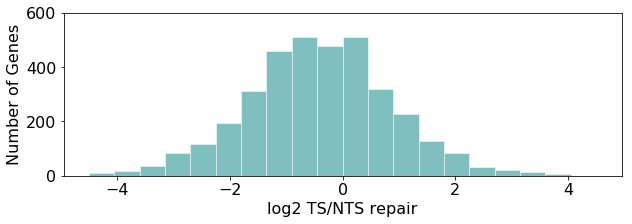

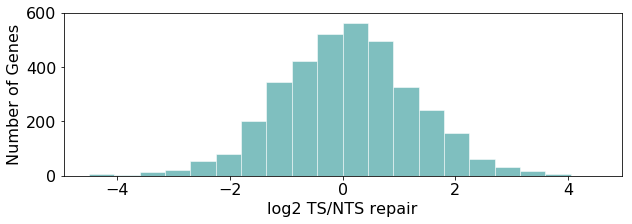

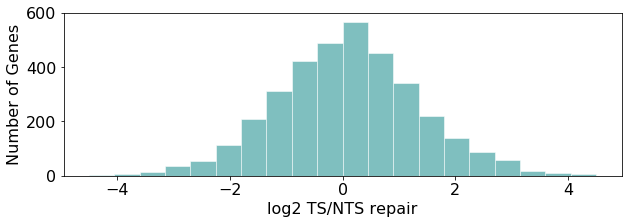

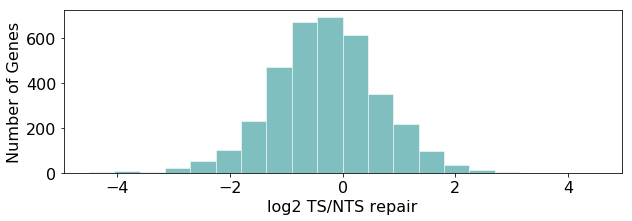

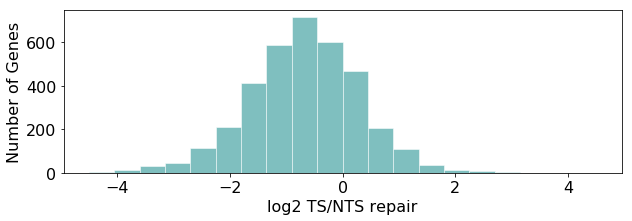

In [41]:
def make_hists(sample_df,sample):
    sample_df.replace(0,1,inplace=True)
    sample_df[sample+'_TS/NTS']=sample_df[sample+'_TS']/sample_df[sample+'_NTS']
    #print(sample_df)
    sample_df=np.log2(sample_df[[sample+'_TS/NTS']])
    #sample_df=sample_df.replace([np.inf, -np.inf,np.nan], 0)
    fig=sample_df[[sample+'_TS/NTS']].plot.hist(alpha=0.5,range=[-4.5,4.5],bins=20,figsize=(10,3),edgecolor='w',color='teal',legend=None)
    major_ticks = np.arange(0, 700, 200) 
    fig.set_yticks(major_ticks)
    fig.tick_params(labelsize=16)
    fig.set_xlabel("log2 TS/NTS repair",fontsize='16')
    fig.set_ylabel("Number of Genes",fontsize='16')
    graph=fig.get_figure()
    #graph.savefig(sample+"_histogram.pdf", transparent=True)
    #fig.set_xlim((0,2.5))
    plt.show()  
    

make_hists(wt_df,'wt')
make_hists(uvrd60_df,'uvrd60')
make_hists(ctd_df,'ctd')
make_hists(gre_df,'gre')
make_hists(uvrd10_df,'uvrd10')


In [68]:
sums=wt_df.sum(axis=0)
total=sums.sum()
print(sums)
total

wt_TS     1180.148640
wt_NTS     281.015472
dtype: float64


1461.1641123611253

In [69]:
wt_df=wt_df/total


In [18]:
wt_df

,wt_TS,wt_NTS
1,0.000170,0.000209
2,0.000085,0.000122
3,0.000140,0.000204
5,0.000098,0.000142
6,0.000165,0.000180
7,0.000046,0.000176
8,0.000021,0.000070
10,0.000200,0.000223
11,0.000119,0.000074
12,0.000072,0.000106


Now we make the correlation plots:

/Users/britney/anaconda/envs/biodata/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/Users/britney/anaconda/envs/biodata/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2


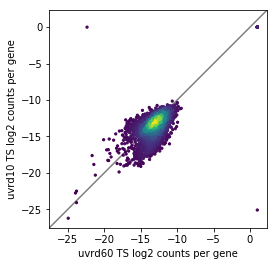

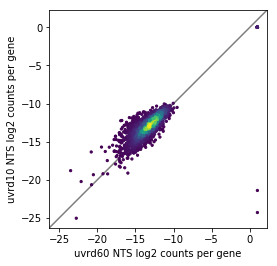

In [35]:
def correlate(first_df,second_df,sample1,sample2,strand):
    first_df=np.log2(first_df)
    first_df=first_df.replace([np.inf, -np.inf], 0)
    first_df.replace(0,1,inplace=True)
    second_df=np.log2(second_df)
    second_df.replace(0,1,inplace=True)
    second_df=second_df.replace([np.inf, -np.inf], 0)
    first_lis=first_df[sample1+'_'+strand].tolist()
    second_lis=second_df[sample2+'_'+strand].tolist()
    x=first_lis
    y=second_lis
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots()
    ax.scatter(x,y,s=5,c=z,alpha=1.0)
    ax.set_xlabel(sample1+" "+strand + " log2 counts per gene")
    ax.set_ylabel(sample2 +" "+strand+" log2 counts per gene")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #fig.savefig(sample2+strand+"correlation_filtered.pdf",transparent=True)
    plt.show() 
    
correlate(uvrd60_df,uvrd10_df,'uvrd60','uvrd10','TS')
correlate(uvrd60_df,uvrd10_df,'uvrd60','uvrd10','NTS')
#correlate(wt_df,uvrd_df,'wt','uvrd','TS')
#correlate(wt_df,uvrd_df,'wt','uvrd','NTS')


Now we make the frequency distrubutions for TS and NTS

/home/britney/miniconda3/envs/aligners/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


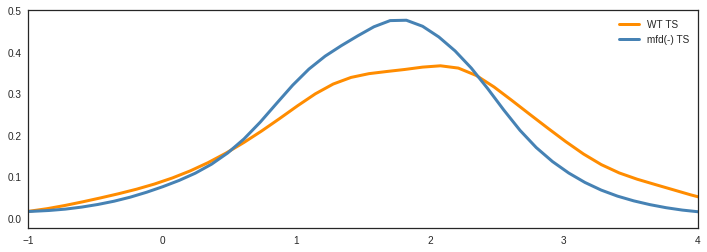

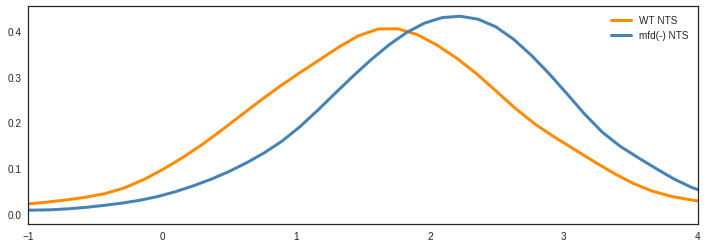

In [12]:
import seaborn as sns
temp_ts= pd.concat([wt_df, mfd_df], axis=1)
temp_ts=np.log2(temp_ts)
temp_ts=temp_ts.replace([np.inf, -np.inf], 0)

f, ax = plt.subplots(figsize=(12, 4))
sns.set_style("white")
#sns.despine()
ax=sns.distplot(temp_ts[['wt_TS']],hist=False,kde_kws={"color": "darkorange", "lw": 3,"label": "WT TS"},ax=ax)
ax=sns.distplot(temp_ts[['mfd_TS']],hist=False,kde_kws={"color": "steelblue", "lw": 3,"label": "mfd(-) TS"},ax=ax)
ax.set_xlim(-1,4)
sns.plt.savefig("TS_smoothed_hist.pdf",transparent=True)
sns.plt.show()
f, ax = plt.subplots(figsize=(12, 4))
ax=sns.distplot(temp_ts[['wt_NTS']],hist=False,kde_kws={"color": "darkorange", "lw": 3,"label": "WT NTS"},ax=ax)
ax=sns.distplot(temp_ts[['mfd_NTS']],hist=False,kde_kws={"color": "steelblue", "lw": 3,"label": "mfd(-) NTS"},ax=ax)
ax.set_xlim(-1,4)
sns.plt.savefig("NTS_smoothed_hist.pdf",transparent=True)
sns.plt.show()

To filter to the top 148 high TCR genes the following code was used:

In [70]:
#wt_df.drop(wt_df[wt_df['wt_TS'] <= wt_df['wt_NTS']].index, inplace=True)

#wt_df.drop(wt_df[wt_df['wt_TS']-wt_df['wt_NTS']<5].index, inplace=True)

joined_df2=wt_df.join(uvrd10_df,how='inner')

joined_df2.head()

,wt_TS,wt_NTS,uvrd10_TS,uvrd10_NTS
24,0.007951,0.000971,0.000078,0.000120
44,0.005976,0.002093,0.000321,0.000159
62,0.006818,0.001245,0.000088,0.000130
103,0.004394,0.000637,0.000182,0.000153
119,0.014946,0.005270,0.000124,0.000205


In [7]:
joined_df2['wt_TS/NTS']=joined_df2['wt_TS']/joined_df2['wt_NTS'] 
joined_df2['uvrd_TS/NTS']=joined_df2['uvrd_TS']/joined_df2['uvrd_NTS'] 
joined_df2.head()

,wt_TS,wt_NTS,uvrd_TS,uvrd_NTS,wt_TS/NTS,uvrd_TS/NTS
20,15.314286,0.055556,22.200000,0.277778,275.657143,79.920000
22,16.055556,3.000000,3.000000,3.285714,5.351852,0.913043
24,39.691176,4.067568,14.617647,5.013514,9.757964,2.915649
50,13.266667,1.755102,6.566667,2.755102,7.558915,2.383457
126,16.303030,2.354839,2.696970,2.612903,6.923205,1.032174


In [16]:
wt_df=joined_df2[['wt_TS','uvrd_TS']]
NTS_df=joined_df2[['wt_NTS','uvrd_NTS']]


In [71]:
def correlate(first_df,sample1,sample2,strand):
    first_df=np.log2(first_df)
    first_df=first_df.replace([np.inf, -np.inf], 0)
    #second_df=np.log2(second_df)
    #second_df=second_df.replace([np.inf, -np.inf], 0)
    first_lis=first_df[sample1+'_'+strand].tolist()
    second_lis=first_df[sample2+'_'+strand].tolist()
    x=first_lis
    y=second_lis
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots()
    ax.scatter(x,y,s=5,c=z,alpha=1.0)
    ax.set_xlabel(sample1+" "+strand + " log2 counts per gene")
    ax.set_ylabel(sample2 +" "+strand+" log2 counts per gene")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #fig.savefig(sample2+strand+"correlation_filtered.pdf",transparent=True)
    plt.show() 

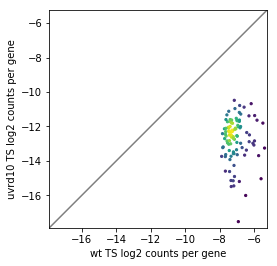

In [72]:
correlate(joined_df2,'wt','uvrd10','TS')

In [17]:


NTS_df.drop(NTS_df[NTS_df['wt_NTS'] <= NTS_df['uvrd_NTS']].index, inplace=True)

print(NTS_df.shape)

(58, 2)


/home/britney/miniconda3/envs/aligners/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
%run TT_content.py